# Introduction

- In the previous notebooks, we have explored the data and segmented the campaigns and customers.

- Now, we want to segment the customers by their individual data.

- This method is often used to help understand the profile of users so that we can strategize communication and campaigns better.

- In this notebook, we are going to use an unsupervise learning algorithm to help us find patterns in an unlabelled data.

- We are going to use `bank-full.csv` for this module.

- The dataset can be obtained from [this website](https://archive.ics.uci.edu/dataset/222/bank+marketing)

# Challenge

- Do the same exact clustering process until you can get customer segmentation and the insight of each cluster towards a similar dataset: [`bank-full.csv`](https://raw.githubusercontent.com/binggas/public-dataset/main/bank%2Bmarketing/bank/bank-full.csv).

- Use this combination to determine each customer:
  1. `age`
  2. `job`
  3. `marital`
  4. `education`
  5. `default`
  6. `housing`
  7. `loan`
  8. `balance`

**Objective: Describe to the bank's customer, why they should subscribed a term deposit**

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Import Data

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/binggas/public-dataset/main/bank%2Bmarketing/bank/bank-full.csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
# Install kmodes if you have not yet
!pip install kmodes

# Import kmodes
from kmodes.kmodes import KModes

In [ ]:
# Select only needed variables
df = df[["age", "job", "marital", "education", "default", "housing", "loan", "balance"]]
df.head()

,age,job,marital,education,default,housing,loan,balance
0,58,management,married,tertiary,no,yes,no,2143
1,44,technician,single,secondary,no,yes,no,29
2,33,entrepreneur,married,secondary,no,yes,yes,2
3,47,blue-collar,married,unknown,no,yes,no,1506
4,33,unknown,single,unknown,no,no,no,1


In [ ]:
# Exploring the number of rows and columns of the dataset
df.shape

(45211, 8)

In [ ]:
# Check duplicate records, since we're only need the characteristic of each customer
df.duplicated().sum()

4163

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
housing      0
loan         0
balance      0
dtype: int64

In [ ]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
housing      object
loan         object
balance       int64
dtype: object



*   Since we are using K-Modes clustering, it has to be categorical values on every variables



In [ ]:
# List categorical columns
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan']

# Loop each element within the list to be changed into the type `category`
for col in cat_cols:
    df[col] = df[col].astype('category')

# Check data types again
df.dtypes

age             int64
job          category
marital      category
education    category
default      category
housing      category
loan         category
balance         int64
dtype: object

* There are 2 variables left with int64 type. Further, we will binned those
variables

In [ ]:
# Check the unique values in each variables
for col in cat_cols:
    print(f'{col}:')
    print(df[col].unique())
    print('\n')

job:
['management', 'technician', 'entrepreneur', 'blue-collar', 'unknown', ..., 'services', 'self-employed', 'unemployed', 'housemaid', 'student']
Length: 12
Categories (12, object): ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', ..., 'student',
                          'technician', 'unemployed', 'unknown']


marital:
['married', 'single', 'divorced']
Categories (3, object): ['divorced', 'married', 'single']


education:
['tertiary', 'secondary', 'unknown', 'primary']
Categories (4, object): ['primary', 'secondary', 'tertiary', 'unknown']


default:
['no', 'yes']
Categories (2, object): ['no', 'yes']


housing:
['yes', 'no']
Categories (2, object): ['no', 'yes']


loan:
['no', 'yes']
Categories (2, object): ['no', 'yes']




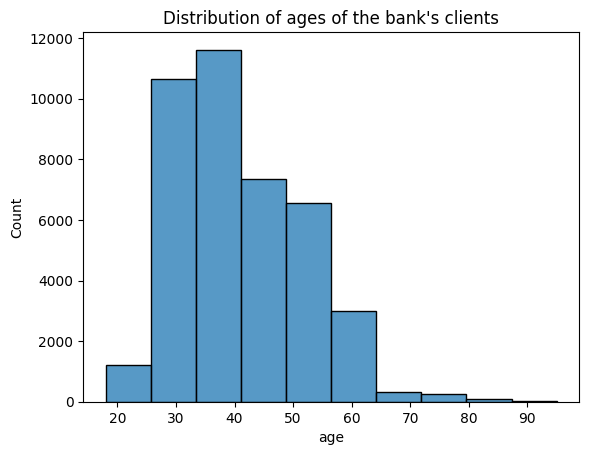

In [ ]:
# Draw plot
sns.histplot(data=df,
             x='age',
             bins=10 # Playaround with different bins number
             )

# Add title
plt.title("Distribution of ages of the bank's clients")

# Add label
plt.ylabel('Count')

# Show the plot
plt.show()

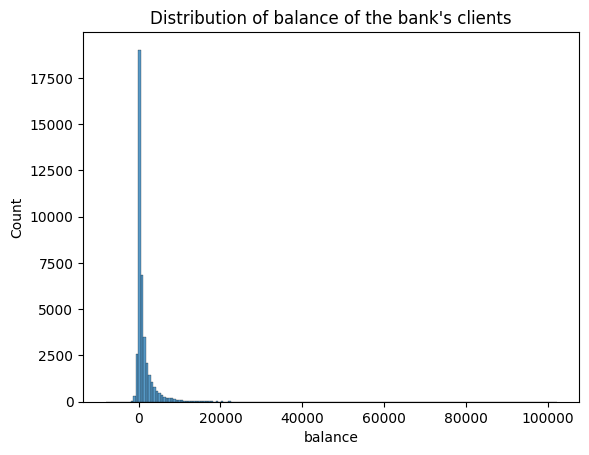

In [ ]:
# Draw plot
sns.histplot(data=df,
             x='balance',
             bins=180 # Playaround with different bins number
             )

# Add title
plt.title("Distribution of balance of the bank's clients")

# Add label
plt.ylabel('Count')

# Show the plot
plt.show()

In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,balance,cluster_k-modes
0,58,management,married,tertiary,no,yes,no,2143,1
1,44,technician,single,secondary,no,yes,no,29,5
2,33,entrepreneur,married,secondary,no,yes,yes,2,2
3,47,blue-collar,married,unknown,no,yes,no,1506,3
4,33,unknown,single,unknown,no,no,no,1,0


In [ ]:
pd.DataFrame(df['balance'].describe(percentiles=[.10,.25,.50,.75,.95]))

,balance
count,41048.000000
mean,1375.931129
std,3055.188601
min,-8019.000000
10%,0.000000
25%,91.000000
50%,469.000000
75%,1449.000000
95%,5773.650000
max,102127.000000


Note: Using the percentiles of balance column, we will classified:
- less than 25th      : Low
- 25th - 50th         : Middle
- 50th - 95th         : High
- higher than 95th    : Very high

## Clustering using K-MODES

In [ ]:
data_kmodes = df.copy()
data_kmodes.head()

,age,job,marital,education,default,housing,loan,balance
0,58,management,married,tertiary,no,yes,no,2143
1,44,technician,single,secondary,no,yes,no,29
2,33,entrepreneur,married,secondary,no,yes,yes,2
3,47,blue-collar,married,unknown,no,yes,no,1506
4,33,unknown,single,unknown,no,no,no,1


In [ ]:
# # Bin `age` column into 10 bins from 10 to 100, change type into category
data_kmodes['age_binned'] = pd.cut(data_kmodes['age'], bins=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).astype('category')

# # Drop `age` column
data_kmodes.drop('age', axis=1, inplace=True)

# Show first 5 rows
data_kmodes.sample(20)

,job,marital,education,default,housing,loan,balance,age_binned
43027,technician,divorced,tertiary,no,yes,no,4276,"(40, 50]"
6711,blue-collar,single,primary,no,yes,no,-443,"(30, 40]"
9395,admin.,married,secondary,no,no,yes,4785,"(30, 40]"
19664,management,divorced,tertiary,no,no,no,1002,"(50, 60]"
15789,management,married,tertiary,no,no,yes,230,"(40, 50]"
38382,self-employed,married,unknown,no,yes,no,14,"(40, 50]"
34401,admin.,married,primary,no,yes,no,2086,"(50, 60]"
18714,technician,married,secondary,no,yes,no,499,"(40, 50]"
38001,blue-collar,married,secondary,no,yes,no,-135,"(50, 60]"
7623,blue-collar,married,secondary,no,yes,no,130,"(40, 50]"


In [ ]:
pd.DataFrame(df['balance'].describe(percentiles=[.05,.25,.50,.75,.95]))

,balance
count,41048.000000
mean,1375.931129
std,3055.188601
min,-8019.000000
5%,-197.000000
25%,91.000000
50%,469.000000
75%,1449.000000
95%,5773.650000
max,102127.000000


In [ ]:
# Bin `balance` column into 5 bins from  to 100, change type into category
data_kmodes['balance_binned'] = pd.cut(data_kmodes['balance'], bins=[-8020, 0, 91, 1449, 5773.65, float('inf')], labels=['Very Low','Low','Middle','High','Very High']).astype('category')

# Show first 5 rows
data_kmodes[data_kmodes['balance_binned'].isna()]

,job,marital,education,default,housing,loan,balance,age_binned,balance_binned


In [ ]:
data_kmodes[data_kmodes['balance']<-1000].sort_values(by='balance', ascending=True)

,job,marital,education,default,housing,loan,balance,age_binned,balance_binned
12909,blue-collar,single,secondary,yes,no,yes,-8019,"(20, 30]",Very Low
15682,management,married,tertiary,yes,no,yes,-6847,"(40, 50]",Very Low
38736,management,divorced,tertiary,no,yes,no,-4057,"(50, 60]",Very Low
7413,management,married,tertiary,yes,yes,no,-3372,"(40, 50]",Very Low
1896,self-employed,married,tertiary,yes,yes,yes,-3313,"(50, 60]",Very Low
...,...,...,...,...,...,...,...,...,...
11389,management,married,tertiary,yes,yes,yes,-1007,"(30, 40]",Very Low
15777,housemaid,single,primary,yes,yes,yes,-1006,"(20, 30]",Very Low
33548,services,married,secondary,no,yes,yes,-1006,"(30, 40]",Very Low
12067,blue-collar,married,secondary,no,yes,no,-1002,"(30, 40]",Very Low


In [ ]:
data_kmodes.isna().any()

job               False
marital           False
education         False
default           False
housing           False
loan              False
balance           False
age_binned        False
balance_binned    False
dtype: bool

In [ ]:
data_kmodes['balance_binned'].value_counts()

Middle       20486
High          8204
Very Low      5716
Low           4589
Very High     2053
Name: balance_binned, dtype: int64

In [ ]:
# Drop `balance` column
data_kmodes.drop('balance', axis=1, inplace=True)

# Show first 5 rows
data_kmodes.head()

,job,marital,education,default,housing,loan,age_binned,balance_binned
0,management,married,tertiary,no,yes,no,"(50, 60]",High
1,technician,single,secondary,no,yes,no,"(40, 50]",Low
2,entrepreneur,married,secondary,no,yes,yes,"(30, 40]",Low
3,blue-collar,married,unknown,no,yes,no,"(40, 50]",High
4,unknown,single,unknown,no,no,no,"(30, 40]",Low


In [ ]:
data_kmodes = pd.get_dummies(data_kmodes, drop_first=True)
data_kmodes.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,"age_binned_(40, 50]","age_binned_(50, 60]","age_binned_(60, 70]","age_binned_(70, 80]","age_binned_(80, 90]","age_binned_(90, 100]",balance_binned_Low,balance_binned_Middle,balance_binned_High,balance_binned_Very High
0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
data_kmodes.nunique()

job_blue-collar             2
job_entrepreneur            2
job_housemaid               2
job_management              2
job_retired                 2
job_self-employed           2
job_services                2
job_student                 2
job_technician              2
job_unemployed              2
job_unknown                 2
marital_married             2
marital_single              2
education_secondary         2
education_tertiary          2
education_unknown           2
default_yes                 2
housing_yes                 2
loan_yes                    2
age_binned_(20, 30]         2
age_binned_(30, 40]         2
age_binned_(40, 50]         2
age_binned_(50, 60]         2
age_binned_(60, 70]         2
age_binned_(70, 80]         2
age_binned_(80, 90]         2
age_binned_(90, 100]        2
balance_binned_Low          2
balance_binned_Middle       2
balance_binned_High         2
balance_binned_Very High    2
dtype: int64

In [ ]:
# Running the K-Modes algorithm for different numbers of clusters:

n_clusters = list(range(2, 9))
costs = []

for n in n_clusters:
    kmodes = KModes(n_clusters=n, init='random', n_init=10, max_iter=500, random_state=42)
    kmodes.fit(data_kmodes)
    cost = kmodes.cost_
    costs.append(cost)

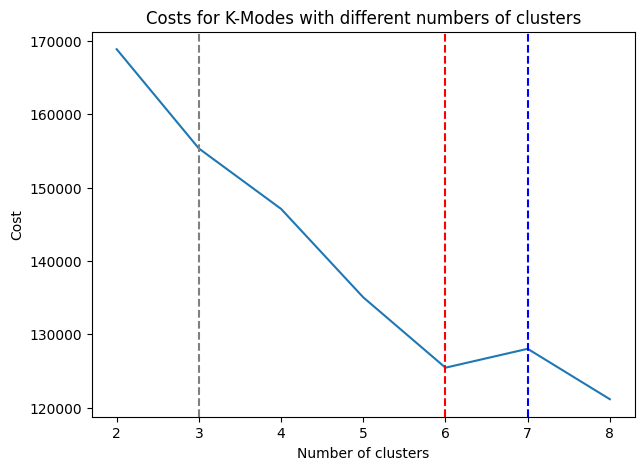

In [ ]:
# Plotting the cost:

plt.figure(figsize=(7,5))
plt.plot(n_clusters, costs)
plt.axvline(3, linestyle='--', c='grey')
plt.axvline(6, linestyle='--', c='r')
plt.axvline(7, linestyle='--', c='b')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Costs for K-Modes with different numbers of clusters')
plt.show()

In [ ]:
kmodes = KModes(n_clusters=6, init='random', n_init=10, max_iter=500, random_state=42)
df['cluster_k-modes'] = kmodes.fit_predict(data_kmodes)

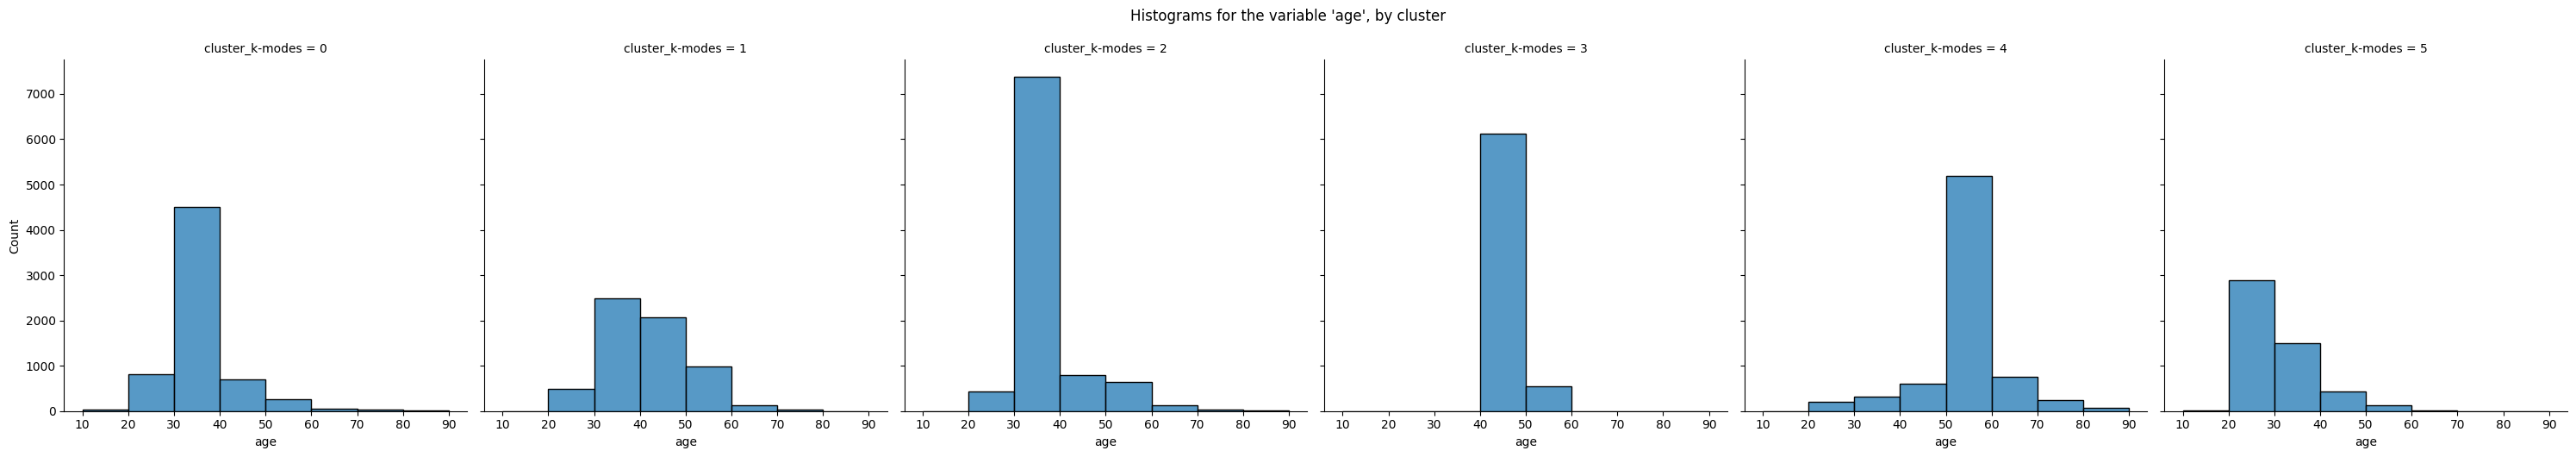

In [ ]:
g = sns.displot(data=df,
                x='age',
                col='cluster_k-modes',
                bins=[10, 20, 30, 40, 50, 60, 70, 80, 90]
                )

g.fig.suptitle("Histograms for the variable 'age', by cluster", y=1.05)

plt.show()

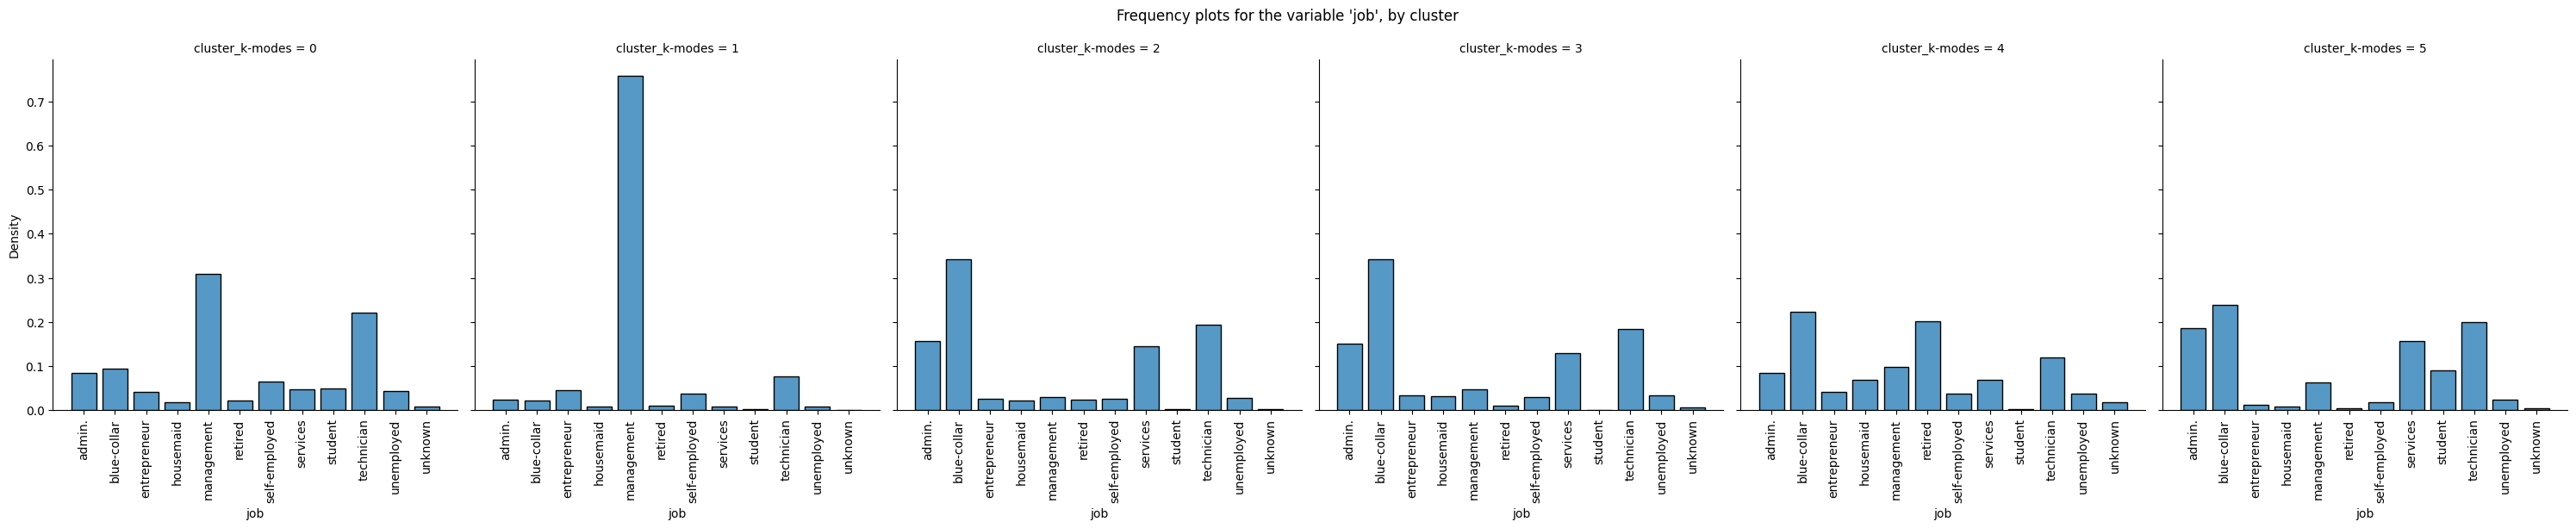

In [ ]:
g = sns.displot(data=df,
                x='job',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)
g.set_xticklabels(rotation=90)

g.fig.suptitle("Frequency plots for the variable 'job', by cluster", y=1.05)

plt.show()

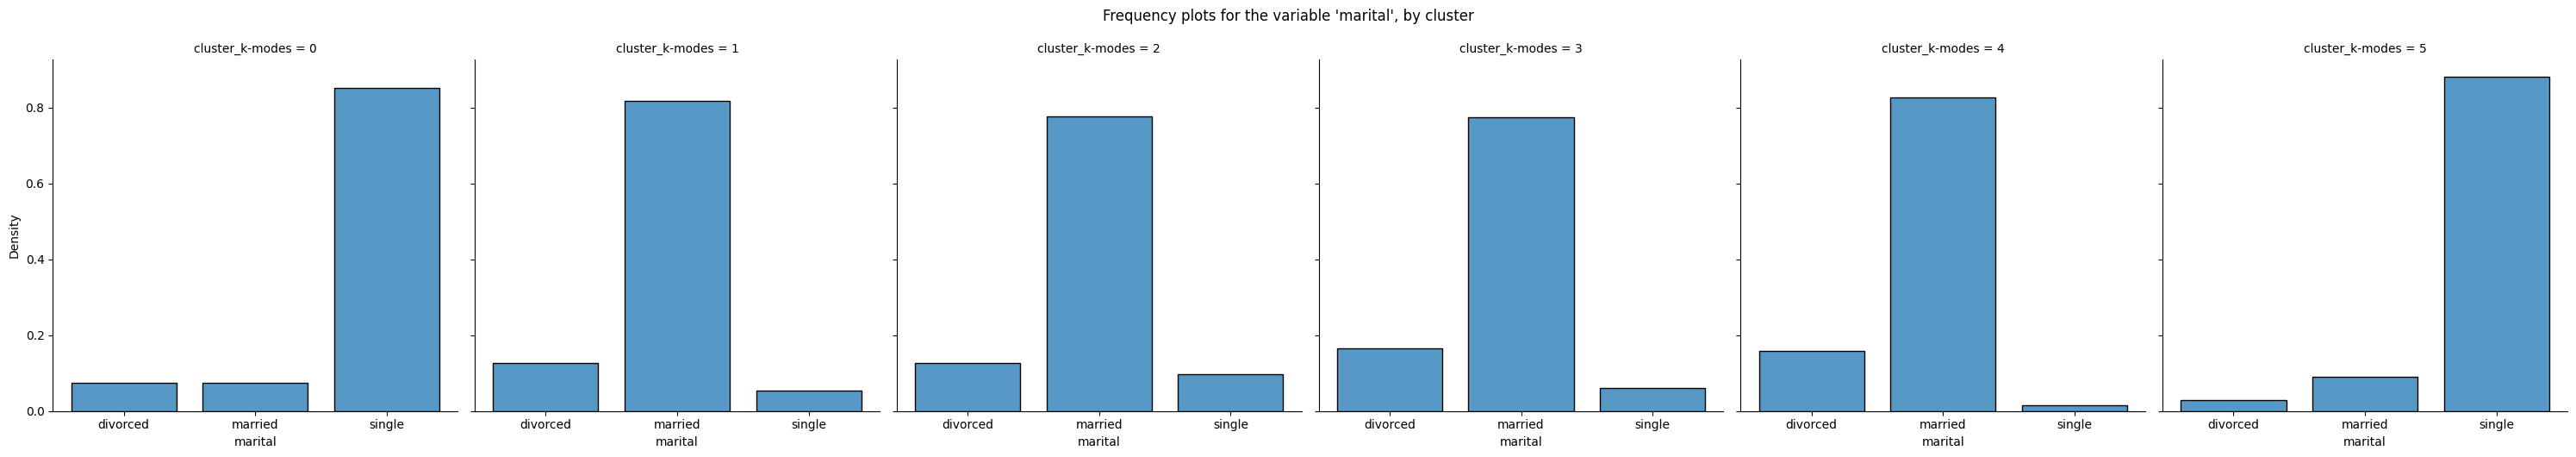

In [ ]:
g = sns.displot(data=df,
                x='marital',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.fig.suptitle("Frequency plots for the variable 'marital', by cluster", y=1.05)

plt.show()

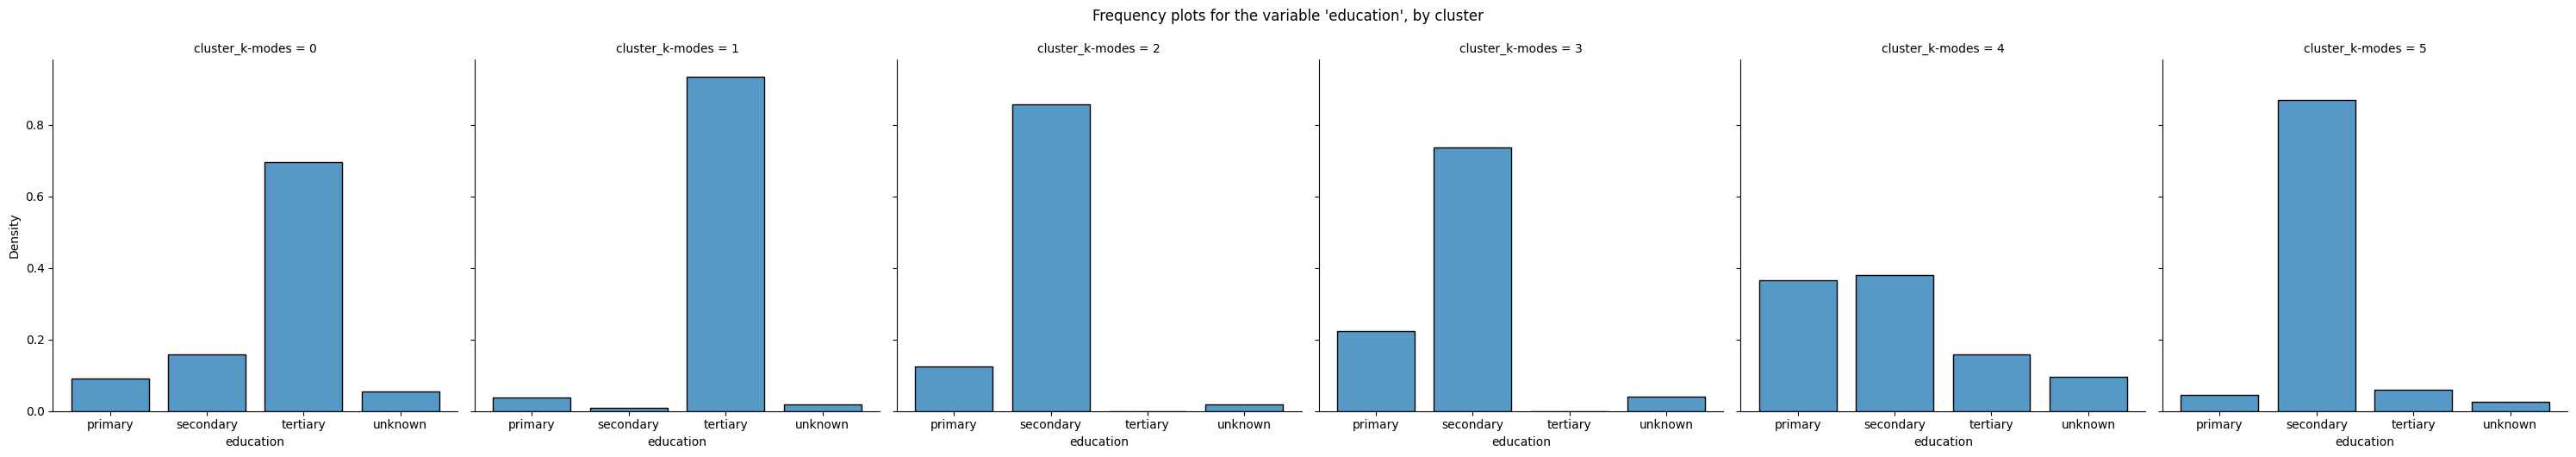

In [ ]:
g = sns.displot(data=df,
                x='education',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.fig.suptitle("Frequency plots for the variable 'education', by cluster", y=1.05)

plt.show()

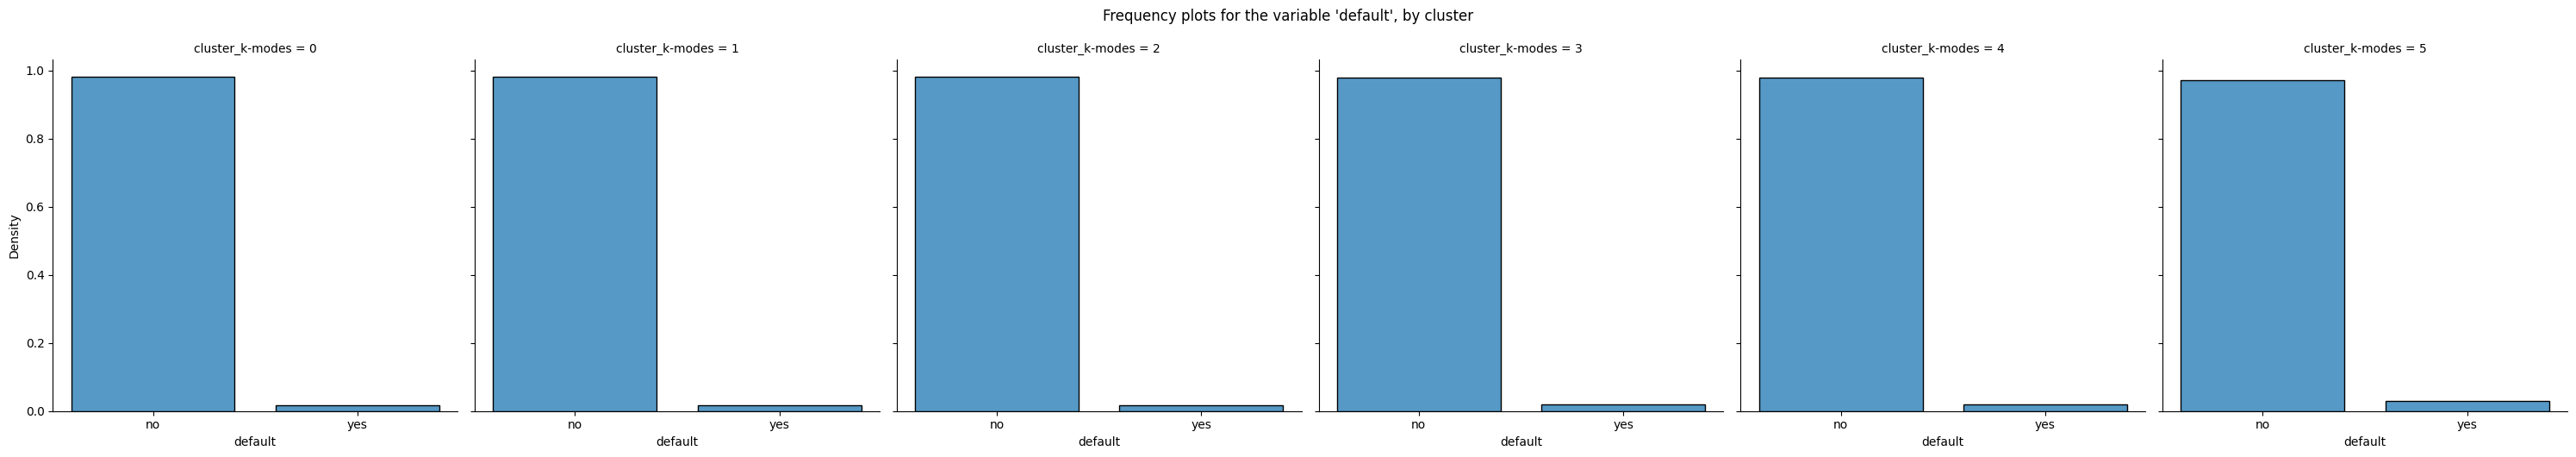

In [ ]:
g = sns.displot(data=df,
                x='default',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.fig.suptitle("Frequency plots for the variable 'default', by cluster", y=1.05)

plt.show()

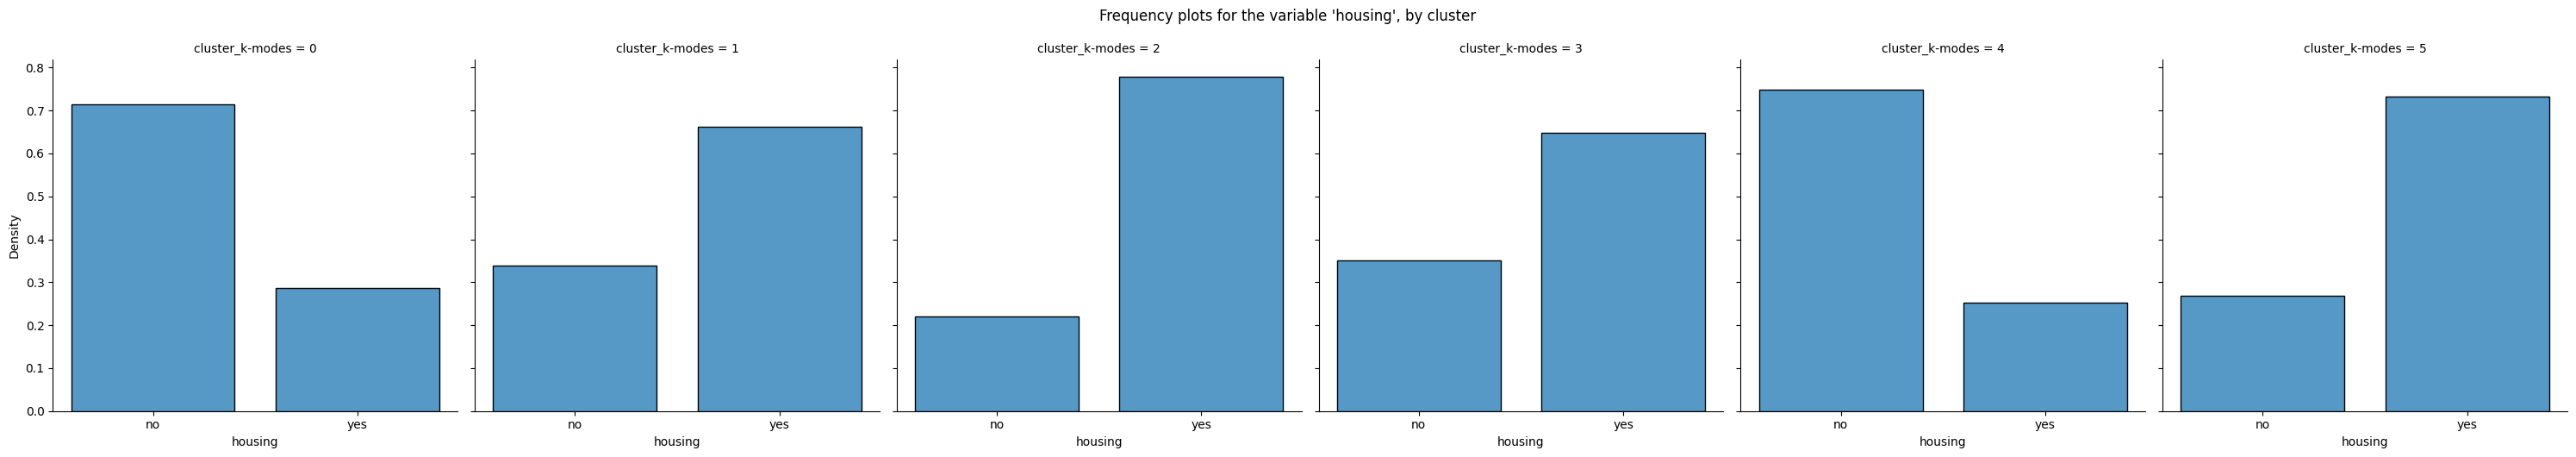

In [ ]:
g = sns.displot(data=df,
                x='housing',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.fig.suptitle("Frequency plots for the variable 'housing', by cluster", y=1.05)

plt.show()

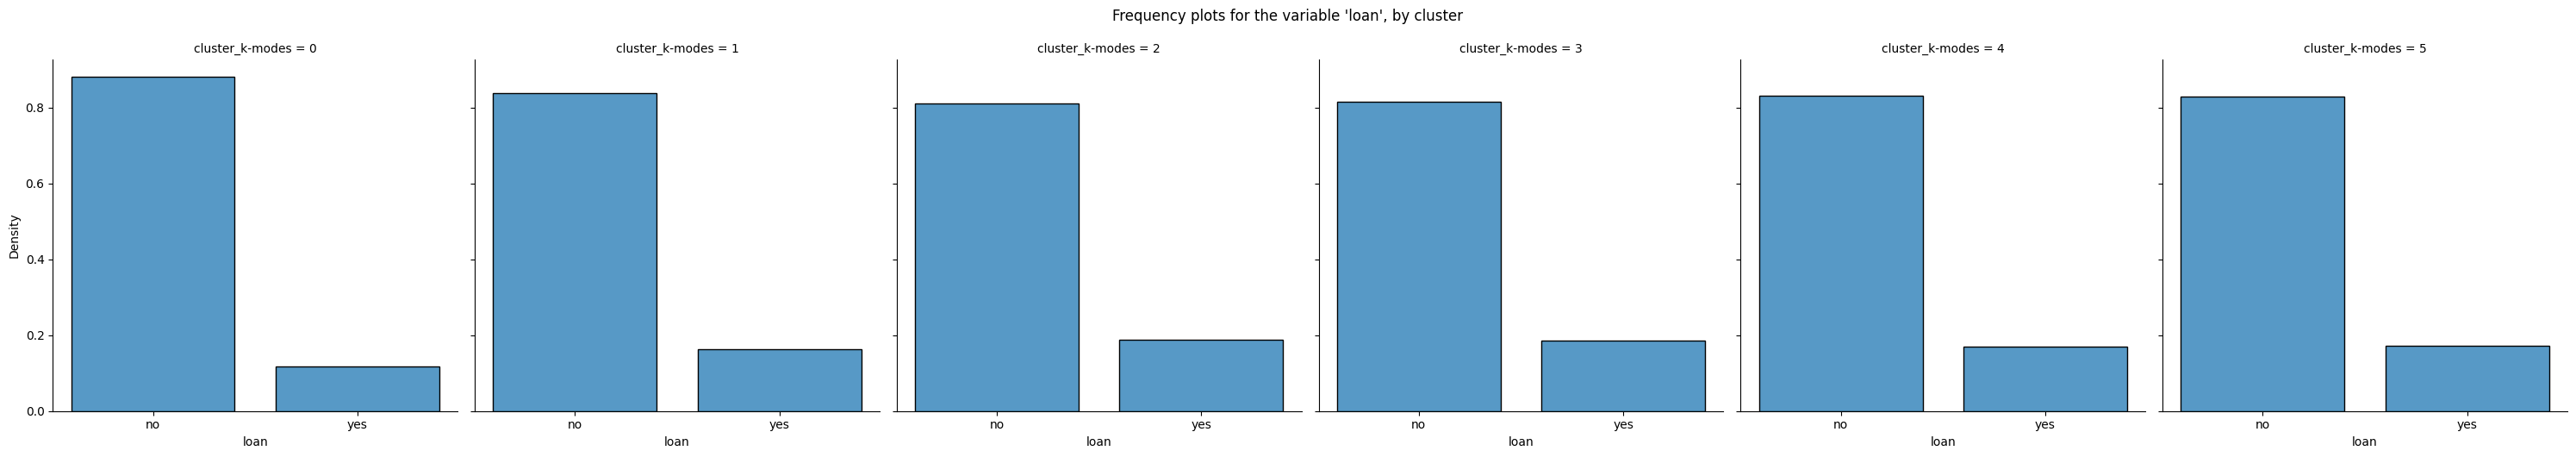

In [ ]:
g = sns.displot(data=df,
                x='loan',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.fig.suptitle("Frequency plots for the variable 'loan', by cluster", y=1.05)

plt.show()

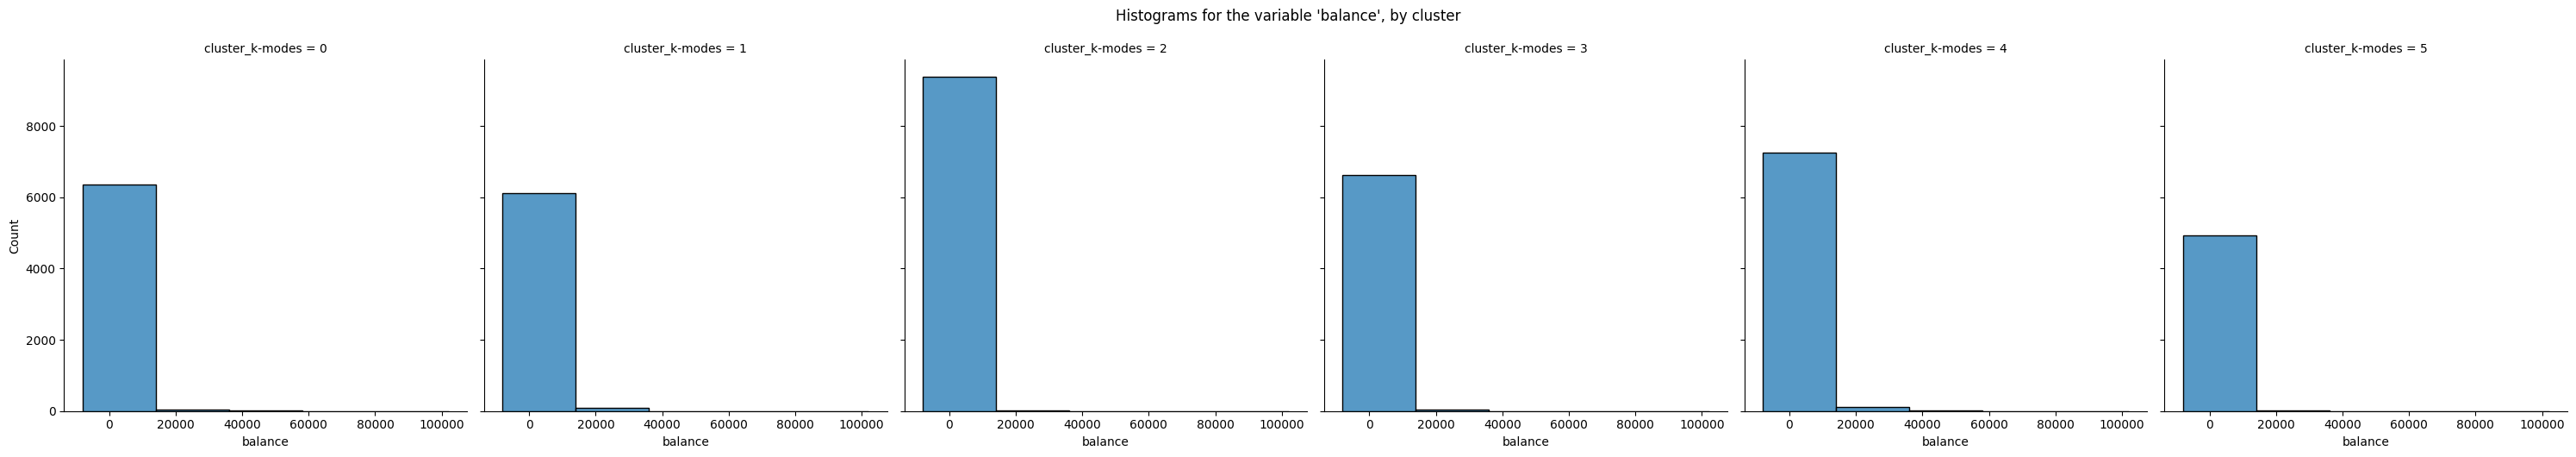

In [ ]:
g = sns.displot(data=df,
                x='balance',
                col='cluster_k-modes',
                bins=[-8020, 0, 91, 1449, 5773.65, float('inf')]
                # labels=['Very Low','Low','Middle','High','Very High']
                )

g.fig.suptitle("Histograms for the variable 'balance', by cluster", y=1.05)

plt.show()

In [ ]:
def balance_binned(balance):
  if balance <= 91:
    return 'Low'
  elif 91.01 <= balance <= 1449:
    return 'Middle'
  elif 1449.01 <= balance <= 5773.65:
    return 'High'
  else:
    return 'Very High'

In [ ]:
df['balance_binned'] = df['balance'].apply(balance_binned)

In [ ]:
df['balance_binned'].value_counts()

Middle       20486
Low          10305
High          8204
Very High     2053
Name: balance_binned, dtype: int64

In [ ]:
df.sample(5)

,age,job,marital,education,default,housing,loan,balance,cluster_k-modes,balance_binned
3637,52,technician,divorced,secondary,no,yes,no,409,2,Middle
32134,32,technician,married,secondary,no,yes,yes,-292,2,Low
26950,30,management,single,secondary,no,yes,no,8101,5,Very High
22761,30,management,married,tertiary,no,no,no,604,1,Middle
7010,45,admin.,married,secondary,no,yes,yes,935,3,Middle


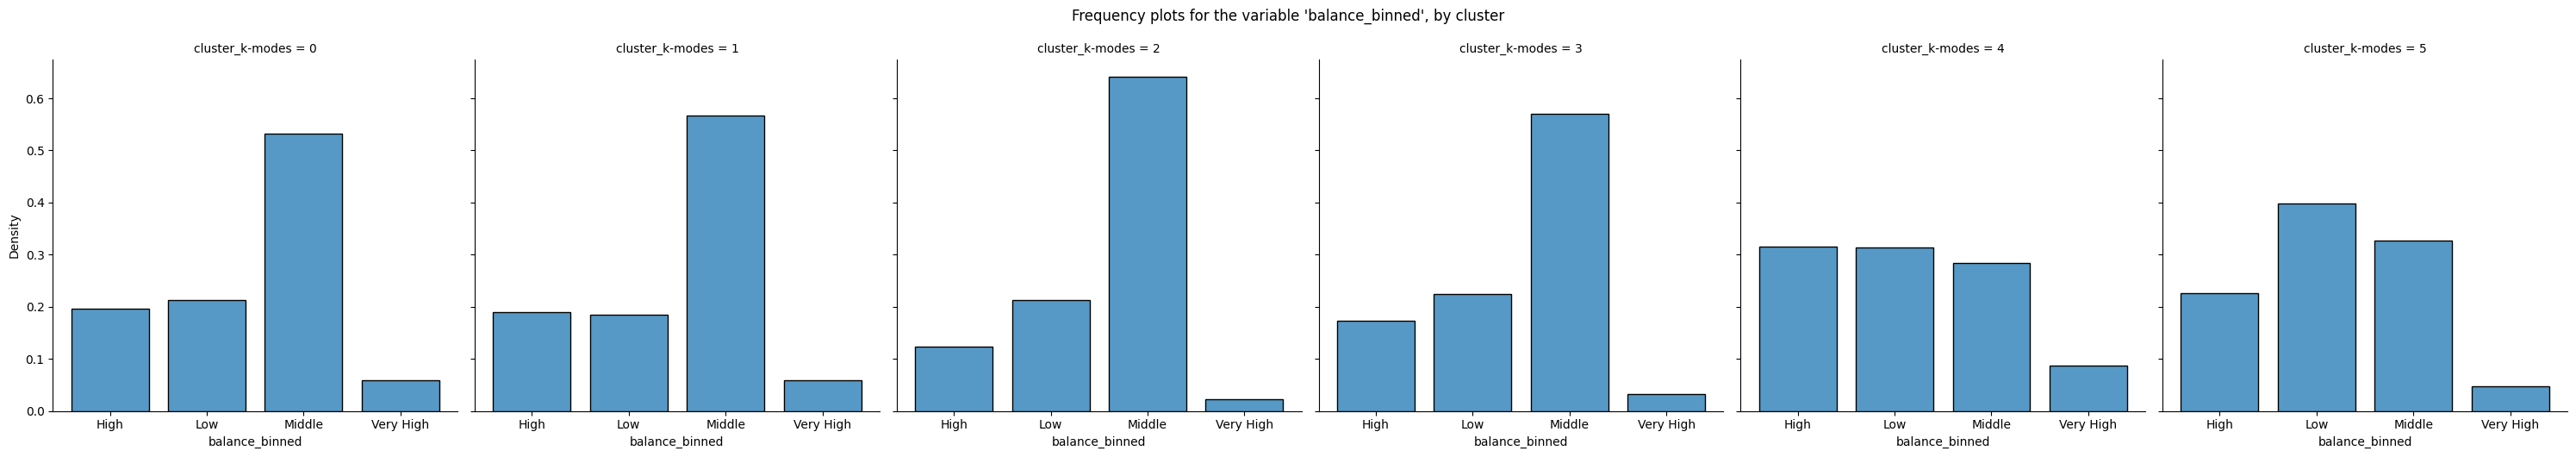

In [ ]:
g = sns.displot(data=df,
                x='balance_binned',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.fig.suptitle("Frequency plots for the variable 'balance_binned', by cluster", y=1.05)

plt.show()

| Variable\Cluster |1 |2 | 3| 4| 5 | 6|
|-|-|-|-|-|-|-|
|`age`| 30-40 | 30-50 | 30-40 | 40-50 | 50-60 | 20-30|
|`job`| management, technician | management | admin, blue-collar, technician | admin, blue-collar, technician | blue-collar, retired, technician| admin, blue-collar, technician |
|`marital`| single| married | married|married|married|single |
|`education`| tertiary|tertiary|secondary|secondary|primary, secondary| secondary |
|`default`| no | no | no | no |no|no|
|`housing`| no | yes | yes | yes | no|yes|
|`loan`| no | no | no | no | no|no|
|`balance`| middle | middle | middle | middle | low, middle, high | low, middle, high|

- What can you learn about the customer profile?

- Find the clusters from the data.

- Conclude the customer profile for each cluster.

## Conclusion & Recommendations

| Cluster | Conclusion/Recommendation |
|--|--|
|1 | Based on the characteristics above, people in this cluster are on a low risk level of financial. To reach their financial freedom, I think it's a good choice if they subscribe to a term deposit, because term deposits can offer a safe and stable option for growing their savings with fixed interest rates over a specified period.    |
|2 | On cluster 2, reason why they should subscribe to a term deposits because they are married and has a housing loan. Subscribing will help them protect the future of their family, whether to their children education or emergency fund. But, since they are in middle level, which sometimes need more liquid asset, it's better to diverse the kind of investments, including stocks or bonds|
|3 | Same with cluster 2, because it's similar characteristics|
|4 | Same with cluster 2, because it's similar characteristics|
|5 | Saving balance to a term deposit in this cluster can offer a safe and stable option for growing their savings too |
|6 | Subscribing term deposit within this group can be a strategic move to achieve short-term financial objectives, whether it's funding higher education pursuits or investing in skill development to elevate one's career trajectory.|

# End of Notebook